In [8]:
import torch
import os
import sys

sys .path.append(os.path.abspath(".."))
from models.tgcn_model import TGCNModel
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt


df= pd.read_hdf("../data/METR-LA.h5")
data = (df.values-df.values.mean())/df.values.std()

train_losses = np.load("../checkpoints/train_losses.npy")
print ("Num of epochs: ", len(train_losses))

Num of epochs:  500


In [9]:
N = 207
seq_len = 12
pred_len = 3

A_norm = torch.load("../data/adj_norm_METR_LA.pt")

model = TGCNModel(
    num_nodes=N,
    in_feat=1,
    gcn_hidden=16,
    seq_len=seq_len,
    pred_len=pred_len,
    A_norm=A_norm
)

model.load_state_dict(
    torch.load("../checkpoints/tgcn_metrla.pth", map_location="cpu")
)

model.eval()

TGCNModel(
  (gcn1): GCNLayer(
    (linear): Linear(in_features=1, out_features=16, bias=True)
  )
  (gcn2): GCNLayer(
    (linear): Linear(in_features=16, out_features=16, bias=True)
  )
  (gru): GRU(16, 16, batch_first=True)
  (fc): Linear(in_features=16, out_features=3, bias=True)
)

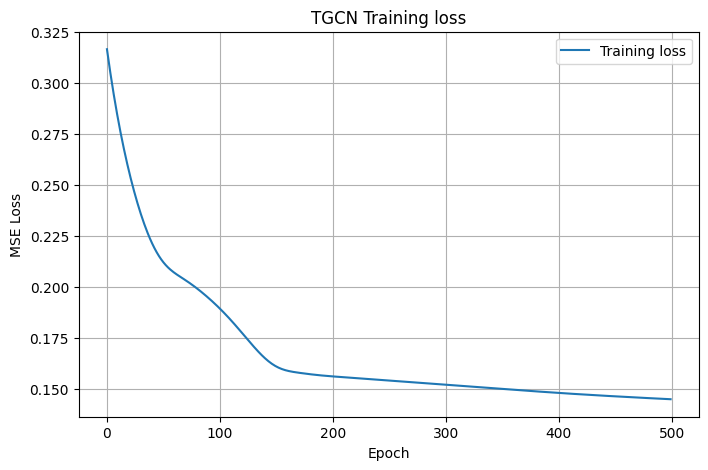

In [18]:
plt.figure(figsize=(8,5))
plt.plot(train_losses, label= "Training loss")
plt.xlabel ("Epoch")
plt.ylabel ("MSE Loss")
plt.title("TGCN Training loss")
plt.legend()
plt.grid(True)
plt.show()

In [11]:
t=1000

X_test = data [t : t+seq_len]
y_true = data [t + seq_len : t +seq_len +pred_len]

X_test = torch.tensor(X_test).unsqueeze(0).float()
y_true = torch.tensor(y_true).float()

with torch.no_grad():
    y_pred = model(X_test)

y_pred = y_pred.squeeze(0)

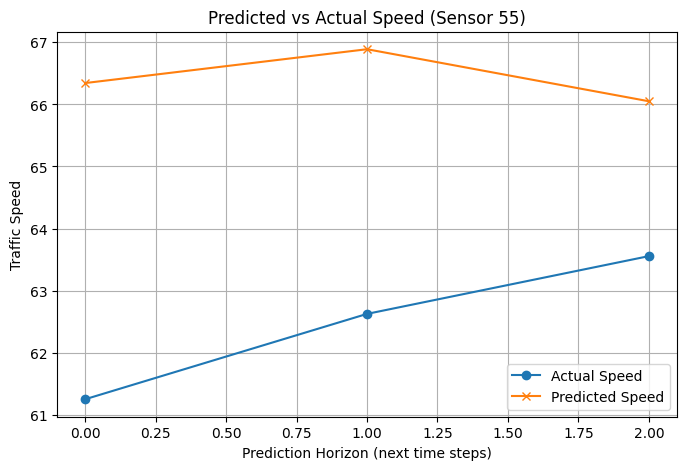

In [16]:
y_true_kmph = y_true* df.values.std() + df.values.mean()
y_pred_kmph = y_pred* df.values.std() + df.values.mean()

sensor_id = 55   # any sensor index

plt.figure(figsize=(8,5))
plt.plot(y_true_kmph[:, sensor_id], marker="o", label="Actual Speed")
plt.plot(y_pred_kmph[:, sensor_id], marker="x", label="Predicted Speed")

plt.xlabel("Prediction Horizon (next time steps)")
plt.ylabel("Traffic Speed")
plt.title(f"Predicted vs Actual Speed (Sensor {sensor_id})")
plt.legend()
plt.grid(True)
plt.show()

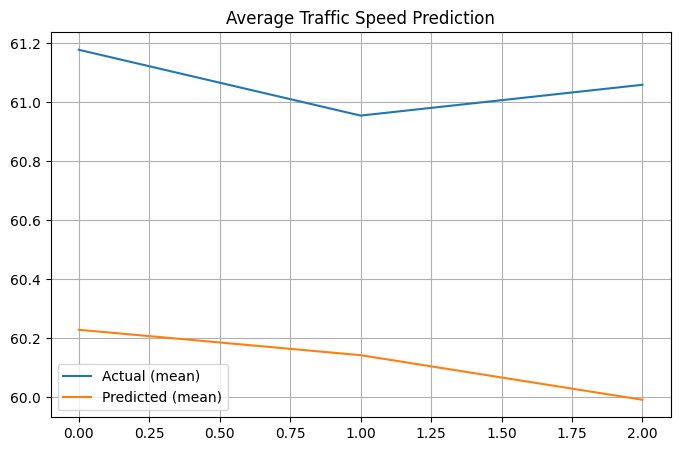

In [19]:
plt.figure(figsize=(8,5))
plt.plot(y_true_kmph.mean(axis=1), label="Actual (mean)")
plt.plot(y_pred_kmph.mean(axis=1), label="Predicted (mean)")
plt.legend()
plt.title("Average Traffic Speed Prediction")
plt.grid(True)
plt.show()